In [1]:
import os
import sys
import numpy as np

BASE_DIR = ''

In [64]:
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [65]:
# Big and unbalanced copus path 'data/subjects'
SUBJECT_DIR = os.path.join(BASE_DIR, 'data/subjects') # Collect path to subjects directory

texts = []                                      # list of text samples
labels_index = {}                               # dictionary, label name to numeric id
labels = []                                     # list of label ids
for name in sorted(os.listdir(SUBJECT_DIR)):    # Go through all subdirectories 
    path = os.path.join(SUBJECT_DIR, name)      # Collect each path to subdir
    if os.path.isdir(path):                     
        label_id = len(labels_index)
        labels_index[name] = label_id           # Collect id to each sub directory labels. 1 level deep
        for fname in sorted(os.listdir(path)):
            if fname.endswith(".txt"):
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    t = t[0:]
                    texts.append(t)             # Append each text from file to text list
                labels.append(label_id)         # Append each label (1-3) to labels list

print(labels_index)

{'_ipynb_checkpoints': 0, 'biology': 1, 'geography': 2, 'physics': 3}


In [ ]:
#!pip install --upgrade tensorflow

In [37]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Flatten
from tensorflow.keras.initializers import Constant

In [5]:
from tensorflow.keras.models  import Model

In [66]:
MAX_SEQUENCE = 1000
MAX_NUM_WORDS = 25000

# Vectorize the corpus into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE)

labels = to_categorical(np.asarray(labels))

In [67]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print('Found %s unique tokens.' % len(word_index))

Shape of data tensor: (2502, 1000)
Shape of label tensor: (2502, 4)
Found 23532 unique tokens.


In [71]:
VALIDATION_SPLIT = 0.25

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]


In [72]:
EMBEDDING_DIM = 100

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE,
                            trainable=False)                                    # keep the embeddings fixed


In [49]:
from tensorflow.keras.optimizers import Adam

In [86]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE,), dtype='int32')


embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0021),
              metrics=['acc'])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=9,
          validation_data=(x_val, y_val))


Train on 1877 samples, validate on 625 samples
Epoch 1/9
1877/1877 [==============================] - 9s 5ms/sample - loss: 0.9761 - acc: 0.5333 - val_loss: 0.6628 - val_acc: 0.8000
Epoch 2/9
1877/1877 [==============================] - 8s 4ms/sample - loss: 0.4290 - acc: 0.8492 - val_loss: 0.2904 - val_acc: 0.8848
Epoch 3/9
1877/1877 [==============================] - 8s 4ms/sample - loss: 0.2050 - acc: 0.9387 - val_loss: 0.1778 - val_acc: 0.9392
Epoch 4/9
1877/1877 [==============================] - 8s 4ms/sample - loss: 0.1703 - acc: 0.9457 - val_loss: 0.1671 - val_acc: 0.9488
Epoch 5/9
1877/1877 [==============================] - 8s 4ms/sample - loss: 0.0983 - acc: 0.9718 - val_loss: 0.1078 - val_acc: 0.9616
Epoch 6/9
1877/1877 [==============================] - 8s 4ms/sample - loss: 0.0766 - acc: 0.9771 - val_loss: 0.0853 - val_acc: 0.9664
Epoch 7/9
1877/1877 [==============================] - 8s 4ms/sample - loss: 0.0514 - acc: 0.9840 - val_loss: 0.0902 - val_acc: 0.9744
Epoch 8/

In [87]:
model.evaluate(x_val,  y_val, verbose=2)

625/1 - 1s - loss: 0.0520 - acc: 0.9696


[0.09984317502975464, 0.9696]

In [ ]:
#!pip install ipympl

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


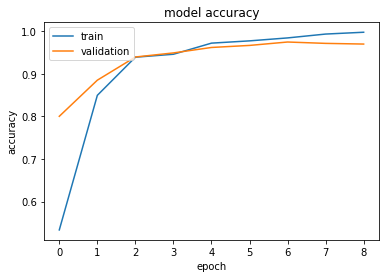

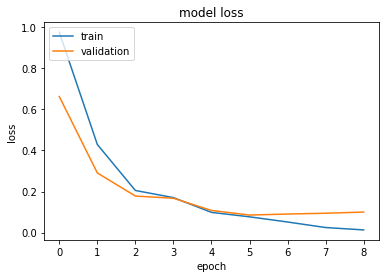

In [88]:
import matplotlib.pyplot as plt


print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()